In [1]:
# Import necessary libraries 
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import math
from math import sqrt
import scipy.stats as st
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%Y-%m-%d')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

In [2]:
# Get the data
assets = ['SPY']

yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date='2019-01-01',
                                                  end_date='2019-12-31',
                                                  time_interval='daily')

# prices_df = pd.DataFrame({
#     a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in assets
# })

# prices_df['SPY'].describe()

df = pd.DataFrame(data['SPY']['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
df.columns = df.columns.map('_'.join)
df = df.reset_index()
df = df.rename(columns = {'formatted_date': 'date',
                                  'h_i_g_h': 'high',
                         'l_o_w': 'low',
                         'o_p_e_n': 'open',
                         'c_l_o_s_e': 'close',
                         'v_o_l_u_m_e': 'volume',
                         'a_d_j_c_l_o_s_e': 'adjclose'})
df.head()

,date,high,low,open,close,volume,adjclose
0,2019-01-02,251.210007,245.949997,245.979996,250.179993,126925200,242.056915
1,2019-01-03,248.570007,243.669998,248.229996,244.210007,144140700,236.280746
2,2019-01-04,253.110001,247.169998,247.589996,252.389999,142628800,244.195160
3,2019-01-07,255.949997,251.690002,252.690002,254.380005,103139100,246.120560
4,2019-01-08,257.309998,254.000000,256.820007,256.769989,102512600,248.432953


In [3]:
# Summary statistics 
df.describe()

,high,low,open,close,volume,adjclose
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000
mean,291.933625,289.426374,290.735538,290.872629,7.008375e+07,283.615941
std,14.891401,15.318617,15.201130,15.009474,2.600331e+07,15.948296
min,248.570007,243.669998,245.979996,244.210007,2.027000e+07,236.280746
25%,283.099991,280.324997,281.794998,281.444992,5.087125e+07,273.491623
50%,292.779999,289.950012,291.309998,291.500000,6.503020e+07,283.987000
75%,300.700012,298.369995,299.744995,299.830002,8.328380e+07,293.155945
max,323.799988,322.279999,323.739990,322.940002,1.787454e+08,318.371063


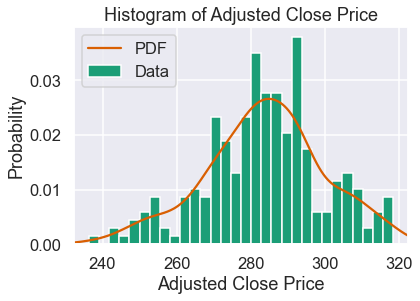

In [4]:
# Histogram of adjusted close price 
x = df['adjclose']
plt.hist(x, density=True, bins=30, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Adjusted Close Price')
plt.title("Histogram of Adjusted Close Price");

In [5]:
# Get the 'actual' dataset for comparison later 
sma = 7

actual = df.iloc[sma-1:,:]
actual = actual[['date', 'adjclose']]
actual

,date,adjclose
6,2019-01-10,250.474442
7,2019-01-11,250.571213
8,2019-01-14,249.042496
9,2019-01-15,251.896729
10,2019-01-16,252.506241
...,...,...
246,2019-12-23,316.675415
247,2019-12-24,316.685272
248,2019-12-26,318.371063
249,2019-12-27,318.292175


In [6]:
# Calculating the short-window simple moving average
df['7_day_SMA'] = df.iloc[:,sma-1].rolling(window=sma).mean()
predict = df[['date', '7_day_SMA']]
predict = predict.iloc[sma-1:,:]
predict

,date,7_day_SMA
6,2019-01-10,245.307824
7,2019-01-11,246.524152
8,2019-01-14,248.347260
9,2019-01-15,249.447484
10,2019-01-16,250.359724
...,...,...
246,2019-12-23,314.207581
247,2019-12-24,314.976898
248,2019-12-26,315.681523
249,2019-12-27,316.365060


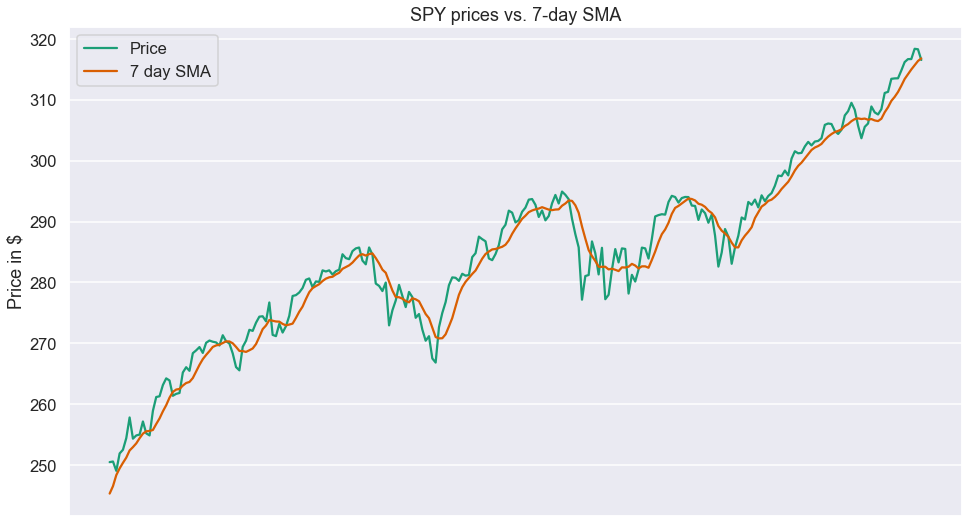

In [7]:
# Visualize the comparison 
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(actual['date'], actual['adjclose'], label='Price')
ax.plot(predict['date'], predict['7_day_SMA'], label = '7 day SMA')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

plt.title('SPY prices vs. 7-day SMA')
plt.show()

In [8]:
# RMSE for the benchmarking model
mse = mean_squared_error(np.array(actual['adjclose']), np.array(predict['7_day_SMA']))
rmse = round(math.sqrt(mse),2)
print(rmse)

2.76


In [19]:
# Feature engineering: add time-series related features 
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.week
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df.head()

,date,high,low,open,close,volume,adjclose,7_day_SMA,dayofweek,quarter,month,year,week,dayofyear,dayofmonth,weekofyear
0,2019-01-02,251.210007,245.949997,245.979996,250.179993,126925200,242.056915,NaN,2,1,1,2019,1,2,2,1
1,2019-01-03,248.570007,243.669998,248.229996,244.210007,144140700,236.280746,NaN,3,1,1,2019,1,3,3,1
2,2019-01-04,253.110001,247.169998,247.589996,252.389999,142628800,244.195160,NaN,4,1,1,2019,1,4,4,1
3,2019-01-07,255.949997,251.690002,252.690002,254.380005,103139100,246.120560,NaN,0,1,1,2019,2,7,7,2
4,2019-01-08,257.309998,254.000000,256.820007,256.769989,102512600,248.432953,NaN,1,1,1,2019,2,8,8,2


In [20]:
# Function to add lags 
def add_lags(data, col_name, num):
    index=np.array([i for i in range(data.shape[0])])
    shift=index+1
    shift=shift[:N]
    for num in shift:
        train_shift=data[col_name].shift(periods=num)
        name='{}_lag_{}'.format(col_name,num)
        data[name]=train_shift
    return data

In [21]:
# Add the lags to the dataset
N = 15
add_lags(df,'adjclose',15)
df.head()

,date,high,low,open,close,volume,adjclose,7_day_SMA,dayofweek,quarter,...,adjclose_lag_6,adjclose_lag_7,adjclose_lag_8,adjclose_lag_9,adjclose_lag_10,adjclose_lag_11,adjclose_lag_12,adjclose_lag_13,adjclose_lag_14,adjclose_lag_15
0,2019-01-02,251.210007,245.949997,245.979996,250.179993,126925200,242.056915,NaN,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,248.570007,243.669998,248.229996,244.210007,144140700,236.280746,NaN,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,253.110001,247.169998,247.589996,252.389999,142628800,244.195160,NaN,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,255.949997,251.690002,252.690002,254.380005,103139100,246.120560,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,257.309998,254.000000,256.820007,256.769989,102512600,248.432953,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Correlation matrix
corr_matrix = df.corr()
corr_matrix['adjclose'].sort_values(ascending=False)

adjclose           1.000000
close              0.998875
high               0.997094
low                0.996090
open               0.993751
adjclose_lag_1     0.990438
7_day_SMA          0.984405
adjclose_lag_2     0.982415
adjclose_lag_3     0.974873
adjclose_lag_4     0.966999
adjclose_lag_5     0.958958
adjclose_lag_6     0.951949
adjclose_lag_7     0.946730
adjclose_lag_8     0.938053
adjclose_lag_9     0.929108
adjclose_lag_10    0.918137
dayofyear          0.917267
month              0.911748
adjclose_lag_11    0.908077
adjclose_lag_12    0.899958
adjclose_lag_13    0.890797
week               0.888675
weekofyear         0.888675
adjclose_lag_14    0.880999
quarter            0.876276
adjclose_lag_15    0.870037
dayofmonth         0.102614
dayofweek         -0.022683
volume            -0.456453
year                    NaN
Name: adjclose, dtype: float64

In [23]:
# Drop low-important features
df1 = df.copy()
df1.drop(['adjclose_lag_12', 'adjclose_lag_13','week','weekofyear','adjclose_lag_14','quarter'
         ,'adjclose_lag_15','dayofmonth', 'dayofweek','volume','year', '7_day_SMA'], axis=1, inplace=True)

df1 = df1.dropna(axis='rows')

df1.head()

,date,high,low,open,close,adjclose,month,dayofyear,adjclose_lag_1,adjclose_lag_2,adjclose_lag_3,adjclose_lag_4,adjclose_lag_5,adjclose_lag_6,adjclose_lag_7,adjclose_lag_8,adjclose_lag_9,adjclose_lag_10,adjclose_lag_11
11,2019-01-17,263.920013,259.959991,260.010010,262.959991,254.421967,1,17,252.506241,251.896729,249.042496,250.571213,250.474442,249.593994,248.432953,246.120560,244.195160,236.280746,242.056915
12,2019-01-18,266.980011,263.000000,264.980011,266.459991,257.808319,1,18,254.421967,252.506241,251.896729,249.042496,250.571213,250.474442,249.593994,248.432953,246.120560,244.195160,236.280746
13,2019-01-22,265.059998,261.059998,264.820007,262.859985,254.325195,1,22,257.808319,254.421967,252.506241,251.896729,249.042496,250.571213,250.474442,249.593994,248.432953,246.120560,244.195160
14,2019-01-23,264.790009,260.660004,264.010010,263.410004,254.857376,1,23,254.325195,257.808319,254.421967,252.506241,251.896729,249.042496,250.571213,250.474442,249.593994,248.432953,246.120560
15,2019-01-24,264.200012,262.079987,263.209991,263.549988,254.992783,1,24,254.857376,254.325195,257.808319,254.421967,252.506241,251.896729,249.042496,250.571213,250.474442,249.593994,248.432953


In [24]:
# Function to normalize the data set 
def normalize_data(df):
    # df on input should contain only one column with the price data (plus dataframe index)
    min = df.min()
    max = df.max()
    x = df 
    
    # time series normalization part
    # y will be a column in a dataframe
    y = (x - min) / (max - min)
    
    return y

In [25]:
# Normalize the variables 
df1['adjclose_norm'] = normalize_data(df1['adjclose'])
df1['high_norm'] = normalize_data(df1['high'])
df1['low_norm'] = normalize_data(df1['low'])
df1['open_norm'] = normalize_data(df1['open'])
df1['adjclose_lag_1_norm'] = normalize_data(df1['adjclose_lag_1'])
df1['adjclose_lag_2_norm'] = normalize_data(df1['adjclose_lag_2'])
df1['adjclose_lag_3_norm'] = normalize_data(df1['adjclose_lag_3'])
df1['adjclose_lag_4_norm'] = normalize_data(df1['adjclose_lag_4'])
df1['adjclose_lag_5_norm'] = normalize_data(df1['adjclose_lag_5'])
df1['adjclose_lag_6_norm'] = normalize_data(df1['adjclose_lag_6'])
df1['adjclose_lag_7_norm'] = normalize_data(df1['adjclose_lag_7'])
df1['adjclose_lag_8_norm'] = normalize_data(df1['adjclose_lag_8'])
df1['adjclose_lag_9_norm'] = normalize_data(df1['adjclose_lag_9'])
df1['adjclose_lag_10_norm'] = normalize_data(df1['adjclose_lag_10'])
df1['adjclose_lag_11_norm'] = normalize_data(df1['adjclose_lag_11'])

df2 = df1[['date', 'adjclose_norm', 'high_norm', 'low_norm', 'open_norm', 'adjclose_lag_1_norm'
          ,'adjclose_lag_2_norm','adjclose_lag_3_norm','adjclose_lag_4_norm','adjclose_lag_5_norm'
          ,'adjclose_lag_6_norm','adjclose_lag_7_norm','adjclose_lag_8_norm','adjclose_lag_9_norm'
          ,'adjclose_lag_10_norm','adjclose_lag_11_norm']]
df2.head()

,date,adjclose_norm,high_norm,low_norm,open_norm,adjclose_lag_1_norm,adjclose_lag_2_norm,adjclose_lag_3_norm,adjclose_lag_4_norm,adjclose_lag_5_norm,adjclose_lag_6_norm,adjclose_lag_7_norm,adjclose_lag_8_norm,adjclose_lag_9_norm,adjclose_lag_10_norm,adjclose_lag_11_norm
11,2019-01-17,0.001511,0.001501,0.000000,0.000000,0.000000,0.000000,0.000000,0.022603,0.021325,0.008385,0.000000,0.000000,0.000000,0.000000,0.077188
12,2019-01-18,0.054385,0.052527,0.048781,0.077985,0.029086,0.009169,0.042196,0.000000,0.022766,0.021772,0.017836,0.034315,0.027806,0.105498,0.000000
13,2019-01-22,0.000000,0.020510,0.017651,0.075475,0.080499,0.037988,0.051206,0.042202,0.000000,0.023244,0.031362,0.051545,0.061201,0.131164,0.105761
14,2019-01-23,0.008309,0.016008,0.011233,0.062765,0.027616,0.088930,0.079528,0.051214,0.042505,0.000000,0.032849,0.064610,0.077969,0.161988,0.131490
15,2019-01-24,0.010424,0.006170,0.034018,0.050212,0.035696,0.036532,0.129590,0.079539,0.051582,0.043397,0.009364,0.066046,0.090684,0.177464,0.162391


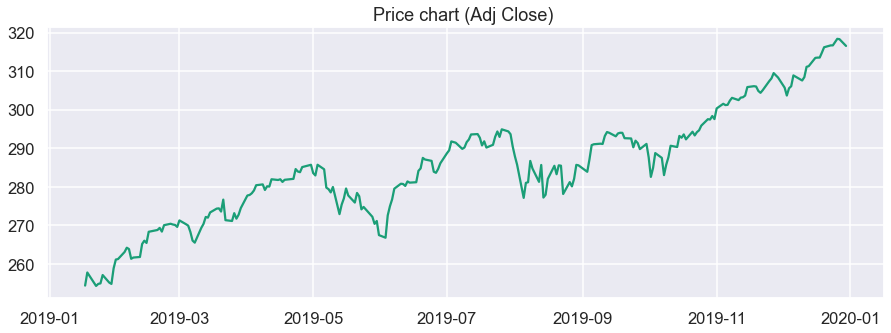

In [26]:
# plot normal chart 
plt.figure(figsize=(15,5))
plt.plot(df1['date'], df1['adjclose'])
plt.title('Price chart (Adj Close) ' )
plt.show()

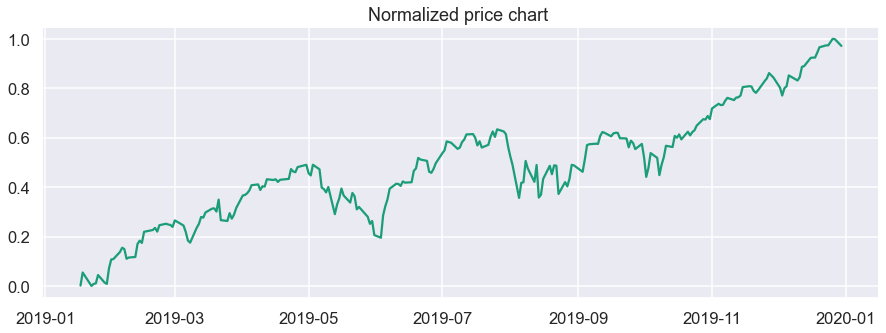

In [27]:
# Plot normalized price chart
plt.figure(figsize=(15,5))
plt.title('Normalized price chart ')
plt.plot(df2['date'], df2['adjclose_norm'])

plt.show()

In [28]:
# Choose milestones to split the data set 
split_1 = '2019-07-01'
split_2 = '2019-10-01'
train = df2.loc[df2['date'] < split_1].copy()
val = df2[df2['date'].between(split_1, split_2)]
test = df2.loc[df2['date'] > split_2].copy()

In [29]:
# Create training, validation, and testing data sets 
X_train = train.iloc[:,2:]
y_train = train['adjclose_norm']
X_test = test.iloc[:,2:]
y_test = test['adjclose_norm']
X_valid = val.iloc[:,2:]
y_valid = val['adjclose_norm']

In [30]:
# Fit the XGBoost model 
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

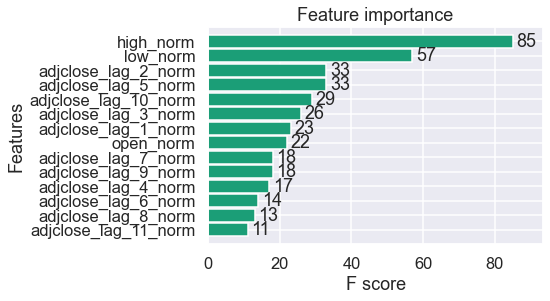

In [31]:
# Find feature importance 
_ = plot_importance(reg, height=0.9)

In [32]:
# Predict the model
y_pred = reg.predict(X_test)

In [33]:
# Print the first 5 predicted values 
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [0.44140223 0.47755157 0.53774965 0.51829577 0.44860113]
y_pred = [0.41813016 0.41652033 0.4923216  0.511054   0.4673998 ]


In [35]:
# Find RMSE of the XGBoost model 
mse_test = mean_squared_error(np.array(y_test), np.array(y_pred))
rmse_test = round(math.sqrt(mse_test),2)
print(rmse_test)

0.28


In [36]:
# Use GridSearchCV to find the optimal parameters 
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[17:47:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:47:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:47:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

In [37]:
# Fit the new paramters into the XGBoost model
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 454 ms, sys: 2.53 ms, total: 456 ms
Wall time: 124 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

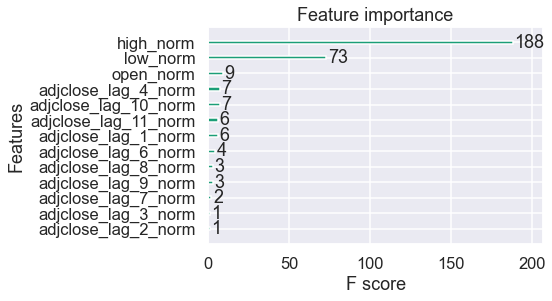

In [38]:
# Find feature importance of the tuned model 
plot_importance(model);

In [39]:
# Predict values for the tuned model 
y_pred_2 = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred_2 = {y_pred_2[:5]}')

y_true = [0.44140223 0.47755157 0.53774965 0.51829577 0.44860113]
y_pred_2 = [0.40079936 0.3988481  0.47161287 0.4913945  0.4529778 ]


In [40]:
# Find RMSE of the tuned model 
mse_2 = mean_squared_error(np.array(y_test), np.array(y_pred_2))
rmse_2 = round(math.sqrt(mse_2),2)
print(rmse_2)

0.3
